In [1]:
import os
from torch.backends import cudnn
import time
from utils.utils import *
from solver import Solver
import seaborn as sns
import matplotlib.pyplot as plt
import json

# import os
# os.environ["OPENBLAS_NUM_THREADS"] = "1"
# os.environ["OMP_NUM_THREADS"] = "1"

In [2]:
config = {
    'win_size': 105,
    'patch_size': [5, 7],
    'lr': 1e-4,
    'loss_fuc': 'MSE',
    'n_heads': 1,
    'e_layers': 3,
    'd_model': 256,
    'rec_timeseries': True,
    'use_gpu': torch.cuda.is_available(),
    'gpu': 0,
    'use_multi_gpu': True,
    'devices': '0,1,2,3',
    'index': 137,
    'num_epochs': 10,
    'batch_size': 256,
    'input_c': 38,
    'output_c': 38,
    'k': 3,
    'dataset': 'SMD',
    'mode': 'test',
    'data_path': 'SMD',
    'model_save_path': 'checkpoints',
    'anormly_ratio': 0.6,
}

config['patch_size'] = [int(patch_index) for patch_index in config['patch_size']]

In [3]:
# def find_nearest(batch_size_buffer, value):
#     return min(batch_size_buffer, key=lambda x: abs(x - value))

# if config['dataset'] in ['UCR', 'UCR_AUG', 'SMD_Ori']:
#     batch_size_buffer = [2, 4, 8, 16, 32, 64, 128, 256, 512]
#     dataset_path = f"dataset/{config['data_path']}/" + config['dataset'] + f"_{config['index']}_train.npy"
#     data_len = np.load(dataset_path).shape[0]
#     config['batch_size'] = find_nearest(batch_size_buffer, data_len / config['win_size'])

# if config['use_gpu'] and config['use_multi_gpu']:
#     config['devices'] = config['devices'].replace(' ', '')
#     config['device_ids'] = [int(id_) for id_ in config['devices'].split(',')]
#     config['gpu'] = config['device_ids'][0]

    
# cudnn.benchmark = True
# if (not os.path.exists(config['model_save_path'])):
#     mkdir(config.model_save_path)
# solver = Solver(config)
    
# if config['mode'] == 'train':
#     print("\n\n")
#     print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
#     print('================ Hyperparameters ===============')
#     for k, v in sorted(config.items()):
#         print(f'{k}: {v}')
#     print('====================  Train  ===================')
#     solver.train()
# elif config['mode'] == 'test':
#     print('====================  Test  ===================')
#     solver.test()

## 250306: from here

### Test energy distribution

In [247]:
pred = np.load('wj_temp/pred_new.npy')
pred_adj = np.load('wj_temp/pred_adj_new.npy')
gt = np.load('wj_temp/gt.npy')
test_energy = np.load('wj_temp/test_energy_new.npy')

# pred = np.load('wj_temp/pred.npy')
# pred_adj = np.load('wj_temp/pred_adj.npy')
# gt = np.load('wj_temp/gt.npy')
# test_energy = np.load('wj_temp/test_energy.npy')

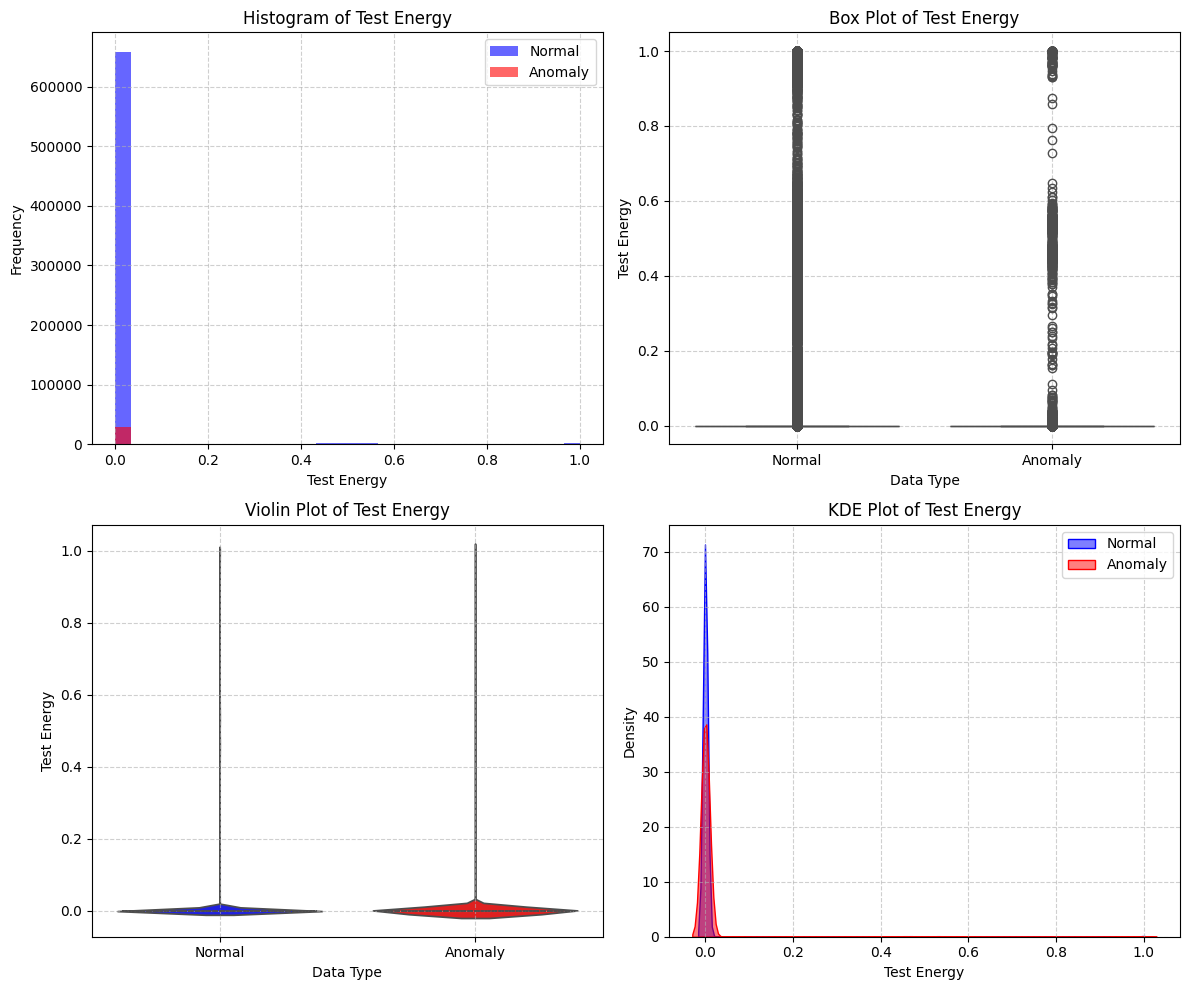

In [248]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def plot_test_energy_distributions(test_energy, gt, bins=30):

    assert test_energy.shape == gt.shape, "test_energy and gt must have the same shape"

    df = pd.DataFrame({"Test Energy": test_energy, "Label": gt})
    df["Label"] = df["Label"].map({0: "Normal", 1: "Anomaly"})

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    axes[0, 0].hist(df[df["Label"] == "Normal"]["Test Energy"], bins=bins, alpha=0.6, color='blue', label="Normal")
    axes[0, 0].hist(df[df["Label"] == "Anomaly"]["Test Energy"], bins=bins, alpha=0.6, color='red', label="Anomaly")
    axes[0, 0].set_title("Histogram of Test Energy")
    axes[0, 0].set_xlabel("Test Energy")
    axes[0, 0].set_ylabel("Frequency")
    axes[0, 0].legend()
    axes[0, 0].grid(True, linestyle="--", alpha=0.6)

    sns.boxplot(x="Label", y="Test Energy", data=df, palette={"Normal": "blue", "Anomaly": "red"}, ax=axes[0, 1])
    axes[0, 1].set_title("Box Plot of Test Energy")
    axes[0, 1].set_xlabel("Data Type")
    axes[0, 1].set_ylabel("Test Energy")
    axes[0, 1].grid(True, linestyle="--", alpha=0.6)

    sns.violinplot(x="Label", y="Test Energy", data=df, palette={"Normal": "blue", "Anomaly": "red"}, inner="quartile", ax=axes[1, 0])
    axes[1, 0].set_title("Violin Plot of Test Energy")
    axes[1, 0].set_xlabel("Data Type")
    axes[1, 0].set_ylabel("Test Energy")
    axes[1, 0].grid(True, linestyle="--", alpha=0.6)

    sns.kdeplot(df[df["Label"] == "Normal"]["Test Energy"], fill=True, color="blue", label="Normal", alpha=0.5, ax=axes[1, 1])
    sns.kdeplot(df[df["Label"] == "Anomaly"]["Test Energy"], fill=True, color="red", label="Anomaly", alpha=0.5, ax=axes[1, 1])
    axes[1, 1].set_title("KDE Plot of Test Energy")
    axes[1, 1].set_xlabel("Test Energy")
    axes[1, 1].set_ylabel("Density")
    axes[1, 1].legend()
    axes[1, 1].grid(True, linestyle="--", alpha=0.6)

    plt.tight_layout()
    plt.show()

plot_test_energy_distributions(test_energy, gt)

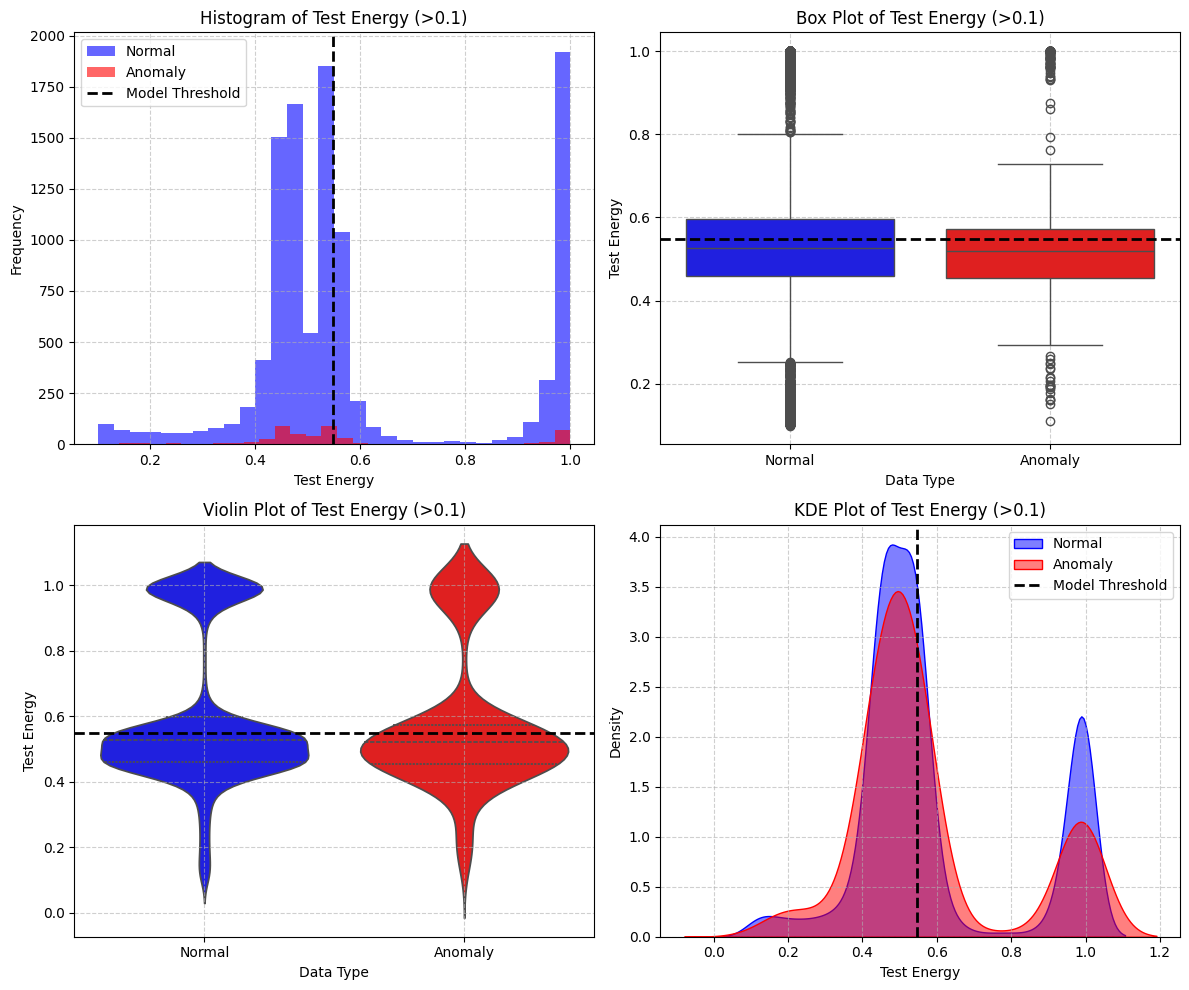

In [250]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def plot_test_energy_distributions(test_energy, gt, bins=30, threshold=0.1, model_threshold=0.5477060079574585):
    """
    Plots Histogram, Boxplot, Violin Plot, and KDE for Test Energy distribution
    of Normal vs Anomaly data, filtering values above a certain threshold.

    Args:
        test_energy (np.ndarray): Anomaly scores for the test dataset.
        gt (np.ndarray): Ground truth labels (0: normal, 1: anomaly).
        bins (int): Number of bins for histogram.
        threshold (float): Minimum test energy value to include in the plots.
        model_threshold (float): The actual model threshold for anomaly detection.
    """
    assert test_energy.shape == gt.shape, "test_energy and gt must have the same shape"

    # 0.1보다 큰 데이터만 필터링
    high_energy_idx = test_energy > threshold
    filtered_test_energy = test_energy[high_energy_idx]
    filtered_gt = gt[high_energy_idx]

    # 데이터프레임 생성
    df = pd.DataFrame({"Test Energy": filtered_test_energy, "Label": filtered_gt})
    df["Label"] = df["Label"].map({0: "Normal", 1: "Anomaly"})

    # 서브플롯 생성
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # 1️⃣ Histogram
    axes[0, 0].hist(df[df["Label"] == "Normal"]["Test Energy"], bins=bins, alpha=0.6, color='blue', label="Normal")
    axes[0, 0].hist(df[df["Label"] == "Anomaly"]["Test Energy"], bins=bins, alpha=0.6, color='red', label="Anomaly")
    axes[0, 0].axvline(model_threshold, color="black", linestyle="--", linewidth=2, label="Model Threshold")  # 모델 Threshold 수직선 추가
    axes[0, 0].set_title(f"Histogram of Test Energy (>{threshold})")
    axes[0, 0].set_xlabel("Test Energy")
    axes[0, 0].set_ylabel("Frequency")
    axes[0, 0].legend()
    axes[0, 0].grid(True, linestyle="--", alpha=0.6)

    # 2️⃣ Boxplot
    sns.boxplot(x="Label", y="Test Energy", data=df, palette={"Normal": "blue", "Anomaly": "red"}, ax=axes[0, 1])
    axes[0, 1].axhline(model_threshold, color="black", linestyle="--", linewidth=2, label="Model Threshold")  # 모델 Threshold 수평선 추가
    axes[0, 1].set_title(f"Box Plot of Test Energy (>{threshold})")
    axes[0, 1].set_xlabel("Data Type")
    axes[0, 1].set_ylabel("Test Energy")
    axes[0, 1].grid(True, linestyle="--", alpha=0.6)

    # 3️⃣ Violin Plot
    sns.violinplot(x="Label", y="Test Energy", data=df, palette={"Normal": "blue", "Anomaly": "red"}, inner="quartile", ax=axes[1, 0])
    axes[1, 0].axhline(model_threshold, color="black", linestyle="--", linewidth=2, label="Model Threshold")  # 모델 Threshold 수평선 추가
    axes[1, 0].set_title(f"Violin Plot of Test Energy (>{threshold})")
    axes[1, 0].set_xlabel("Data Type")
    axes[1, 0].set_ylabel("Test Energy")
    axes[1, 0].grid(True, linestyle="--", alpha=0.6)

    # 4️⃣ KDE Plot
    sns.kdeplot(df[df["Label"] == "Normal"]["Test Energy"], fill=True, color="blue", label="Normal", alpha=0.5, ax=axes[1, 1])
    sns.kdeplot(df[df["Label"] == "Anomaly"]["Test Energy"], fill=True, color="red", label="Anomaly", alpha=0.5, ax=axes[1, 1])
    axes[1, 1].axvline(model_threshold, color="black", linestyle="--", linewidth=2, label="Model Threshold")  # 모델 Threshold 수직선 추가
    axes[1, 1].set_title(f"KDE Plot of Test Energy (>{threshold})")
    axes[1, 1].set_xlabel("Test Energy")
    axes[1, 1].set_ylabel("Density")
    axes[1, 1].legend()
    axes[1, 1].grid(True, linestyle="--", alpha=0.6)

    plt.tight_layout()
    plt.show()

# 실행 예제 (Threshold 0.1 이상 데이터만 시각화)
plot_test_energy_distributions(test_energy, gt, bins=30, threshold=0.1, model_threshold=0.5477060079574585)


### model output 

In [1]:
import torch
from solver import *

In [221]:
loaded_data = torch.load("wj_temp/saved_data/batch_0.pt")

input_data = loaded_data["input_data"]
labels = loaded_data["labels"]
series = loaded_data["series"]
prior = loaded_data["prior"]

print("Data loaded successfully!")

Data loaded successfully!


In [222]:
test_labels = []
attens_energy = []
series_loss = 0.0
prior_loss = 0.0
win_size = 105
temperature = 50

for u in range(len(prior)):
    if u == 0:
        series_loss = my_kl_loss(series[u], (
                prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                       win_size)).detach()) *temperature
        prior_loss = my_kl_loss(
            (prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                    win_size)),
            series[u].detach()) *temperature
    else:
        series_loss += my_kl_loss(series[u], (
                prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                       win_size)).detach()) *temperature
        prior_loss += my_kl_loss(
            (prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                    win_size)),
            series[u].detach()) *temperature

In [223]:
print(torch.nonzero(labels.sum(dim=1) > 0).squeeze())

tensor([101, 112, 121, 133, 134, 138, 202, 210, 232, 245])


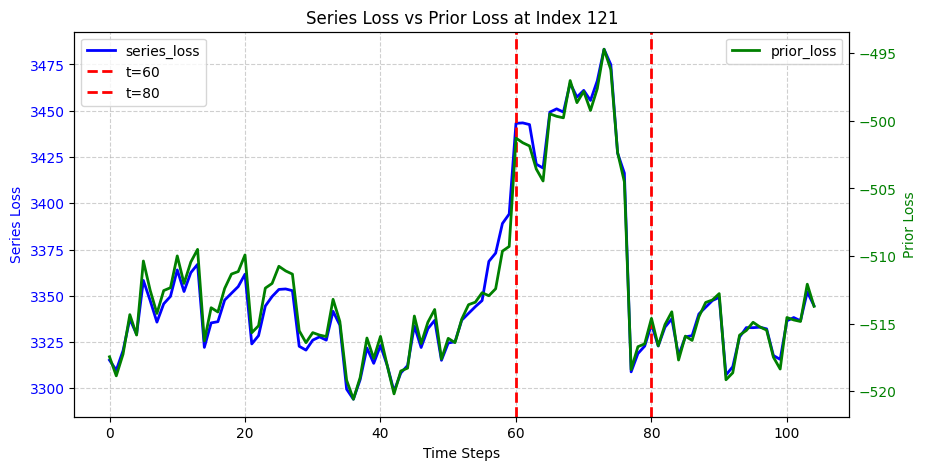

In [224]:
import matplotlib.pyplot as plt
import torch

idx = 121
series_loss_idx = series_loss[idx].cpu().detach().numpy()
prior_loss_idx = prior_loss[idx].cpu().detach().numpy()

anom = torch.where(labels[idx]==1)[0]
start, end = anom[0], anom[-1]

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(series_loss_idx, linestyle='-', linewidth=2, color='b', label="series_loss")
ax1.set_xlabel("Time Steps")
ax1.set_ylabel("Series Loss", color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(prior_loss_idx, linestyle='-', linewidth=2, color='g', label="prior_loss")
ax2.set_ylabel("Prior Loss", color='g')
ax2.tick_params(axis='y', labelcolor='g')

ax1.axvline(x=start, color='r', linestyle='--', linewidth=2, label=f"t={start}")
ax1.axvline(x=end, color='r', linestyle='--', linewidth=2, label=f"t={end}")

plt.title(f"Series Loss vs Prior Loss at Index {idx}")
ax1.grid(True, linestyle='--', alpha=0.6)

ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.show()

# plt.figure(figsize=(10, 5))

# plt.plot(series_loss_idx + prior_loss_idx)
# plt.axvline(x=start, color='r', linestyle='--', linewidth=2, label=f"t={start}")
# plt.axvline(x=end, color='r', linestyle='--', linewidth=2, label=f"t={end}")
# plt.show()

In [225]:
import scipy.ndimage

def compute_anomaly_scores(loss_sum, method="exp", gamma=3, smooth_sigma=3, gaussian_filter=False):
    """
    Computes anomaly scores based on different scaling methods.
    
    Args:
        series_loss (torch.Tensor): Series loss tensor (batch_size, time_length).
        prior_loss (torch.Tensor): Prior loss tensor (batch_size, time_length).
        method (str): Scaling method - "softmax", "minmax", "exp", "sigmoid", "log".
    
    Returns:
        np.ndarray: Anomaly scores (batch_size, time_length).
    """
#     loss_sum = series_loss + prior_loss  # Combine loss values
    
    metric = 0
    loss_sum = loss_sum.detach().cpu()

    if method == "ori":
        metric = loss_sum
    elif method == "softmax":
        metric = torch.softmax(loss_sum, dim=-1)  # Normalize across time
    elif method == "softmax_scaled":
        metric = torch.softmax(loss_sum / 100, dim=-1)  
    elif method == "sigmoid":
        metric = torch.sigmoid(loss_sum / 10000)

    else:
        raise ValueError("Invalid method. Choose from 'softmax', 'minmax', 'exp', 'sigmoid', 'log'.")
        
    if gaussian_filter:
        metric = scipy.ndimage.gaussian_filter1d(metric, sigma=smooth_sigma, axis=-1)

    return metric

In [226]:
methods = ["ori", "softmax", "softmax_scaled", "sigmoid"]

In [236]:
labels.shape

torch.Size([256, 105])

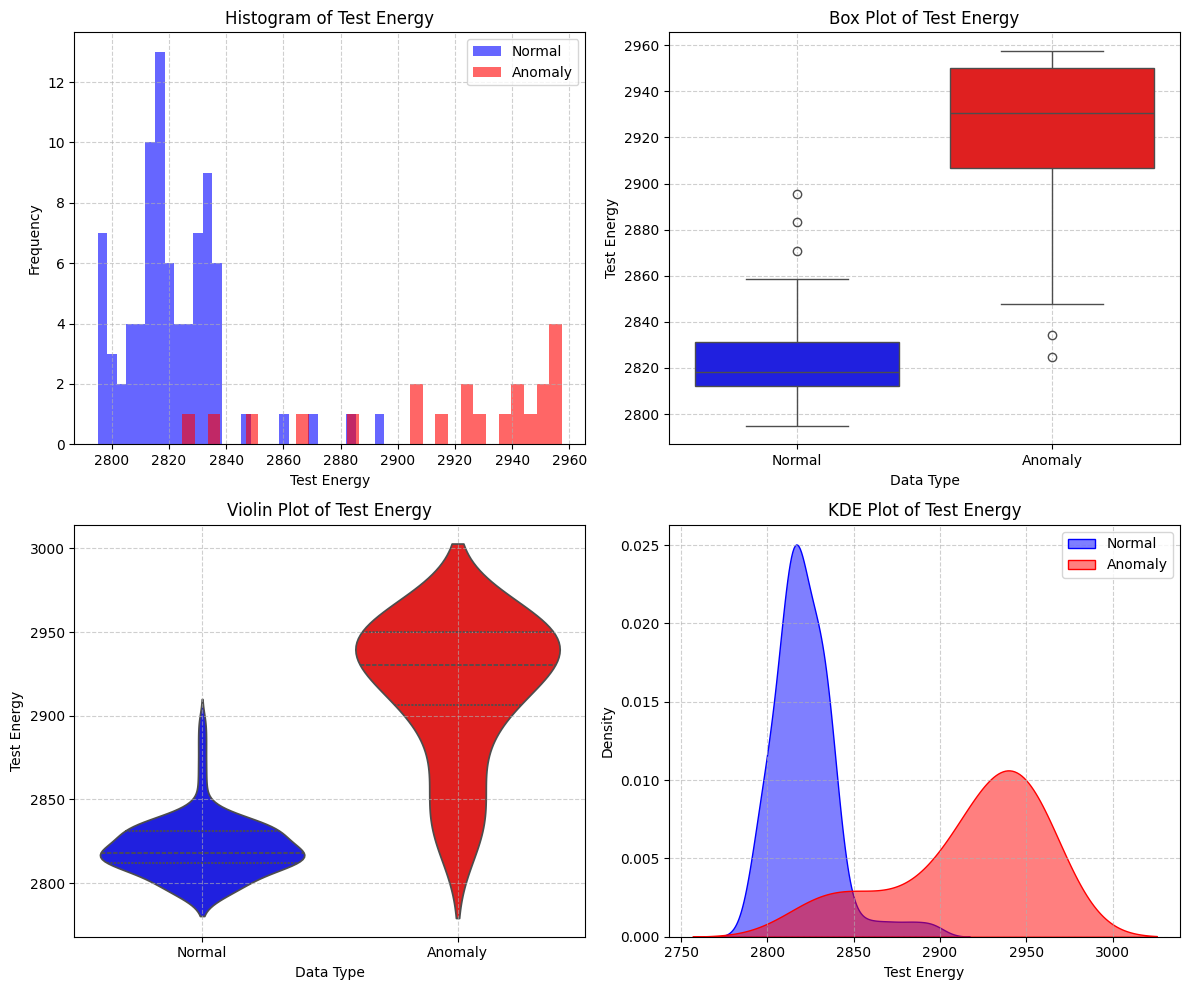

In [240]:
plot_test_energy_distributions(attens_energy['ori'][idx], labels[idx])

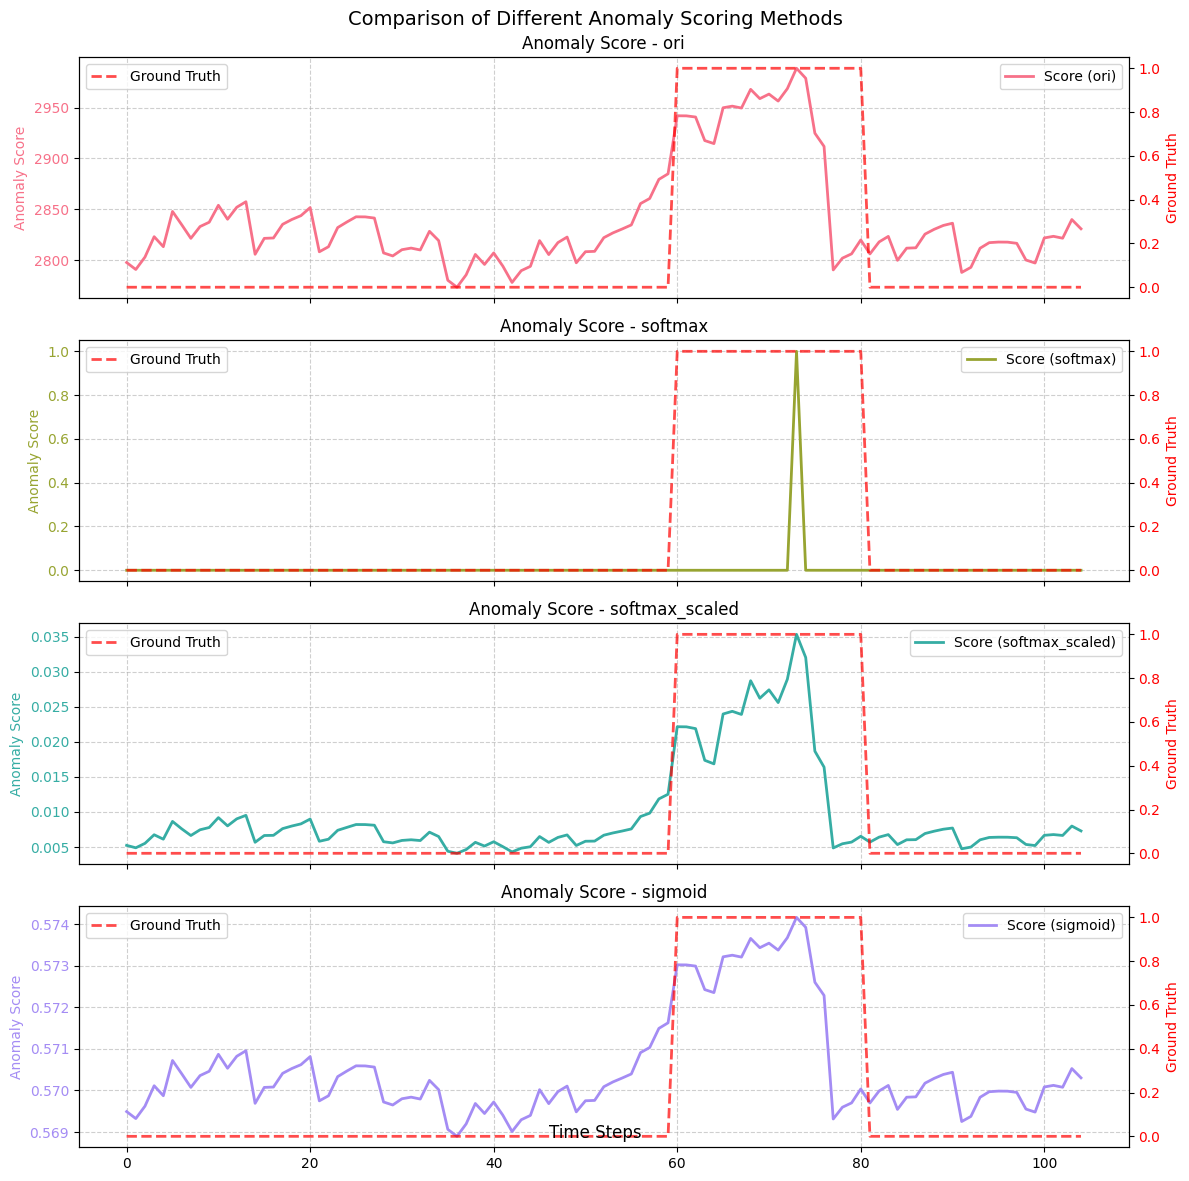

In [251]:
attens_energy = {method: compute_anomaly_scores(series_loss+prior_loss, method, gamma=2) for method in methods}
num_methods = len(methods)
fig, axes = plt.subplots(num_methods, 1, figsize=(12, 3 * num_methods), sharex=True)

if num_methods == 1:
    axes = [axes]

colors = sns.color_palette("husl", num_methods)  

for i, (method, color) in enumerate(zip(methods, colors)):
    ax1 = axes[i]  
    ax2 = ax1.twinx()  

    anomaly_score = np.array(attens_energy[method][idx]).flatten()
    ground_truth = np.array(labels[idx]).flatten()

    # Plot Anomaly Score
    ax1.plot(anomaly_score, label=f"Score ({method})", color=color, linewidth=2)
    ax1.set_ylabel("Anomaly Score", color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.set_title(f"Anomaly Score - {method}")

    # Plot Ground Truth on Secondary y-axis
    ax2.plot(ground_truth, label="Ground Truth", color='r', linestyle="--", alpha=0.7, linewidth=2)
    ax2.set_ylabel("Ground Truth", color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    ax1.legend(loc="upper right")
    ax2.legend(loc="upper left")

fig.text(0.5, 0.04, "Time Steps", ha="center", fontsize=12)
plt.suptitle("Comparison of Different Anomaly Scoring Methods", fontsize=14)
plt.tight_layout()
plt.show()

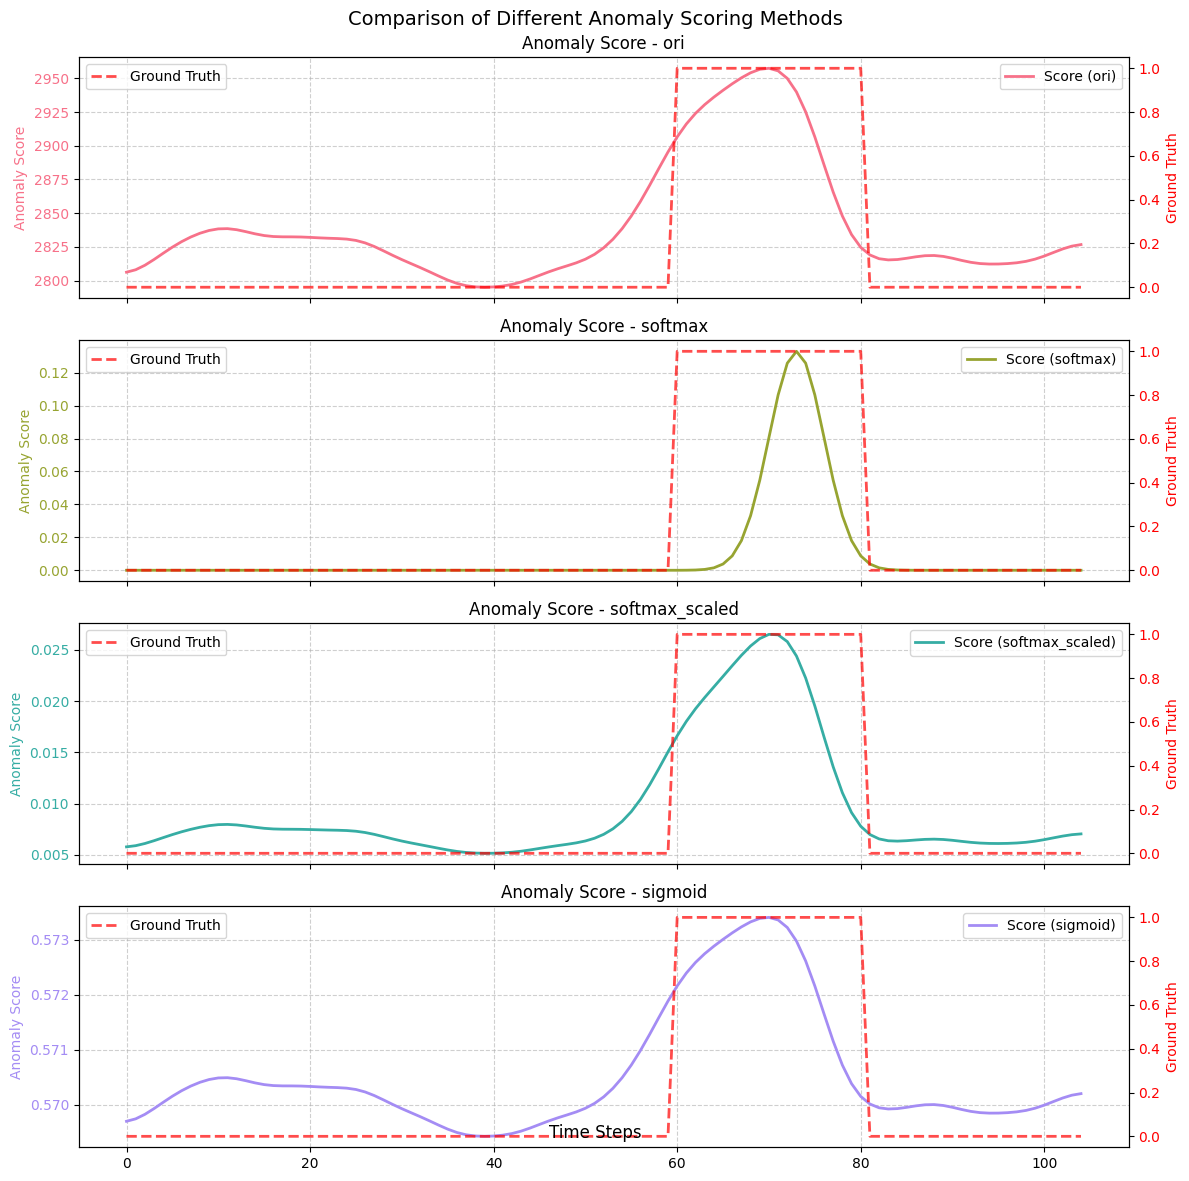

In [252]:
attens_energy = {method: compute_anomaly_scores(series_loss+prior_loss, method, gaussian_filter=True) for method in methods}
num_methods = len(methods)
fig, axes = plt.subplots(num_methods, 1, figsize=(12, 3 * num_methods), sharex=True)

if num_methods == 1:
    axes = [axes]

colors = sns.color_palette("husl", num_methods)  # Generates len(methods) distinct colors

for i, (method, color) in enumerate(zip(methods, colors)):
    ax1 = axes[i]  # Main y-axis for anomaly score
    ax2 = ax1.twinx()  # Secondary y-axis for ground truth

    # Ensure data is 1D for plotting
    anomaly_score = np.array(attens_energy[method][idx]).flatten()
    ground_truth = np.array(labels[idx]).flatten()

    # Plot Anomaly Score
    ax1.plot(anomaly_score, label=f"Score ({method})", color=color, linewidth=2)
    ax1.set_ylabel("Anomaly Score", color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.set_title(f"Anomaly Score - {method}")

    # Plot Ground Truth on Secondary y-axis
    ax2.plot(ground_truth, label="Ground Truth", color='r', linestyle="--", alpha=0.7, linewidth=2)
    ax2.set_ylabel("Ground Truth", color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    # Legends
    ax1.legend(loc="upper right")
    ax2.legend(loc="upper left")

# Set shared x-label
fig.text(0.5, 0.04, "Time Steps", ha="center", fontsize=12)

# Set main title
plt.suptitle("Comparison of Different Anomaly Scoring Methods", fontsize=14)

plt.tight_layout()
plt.show()


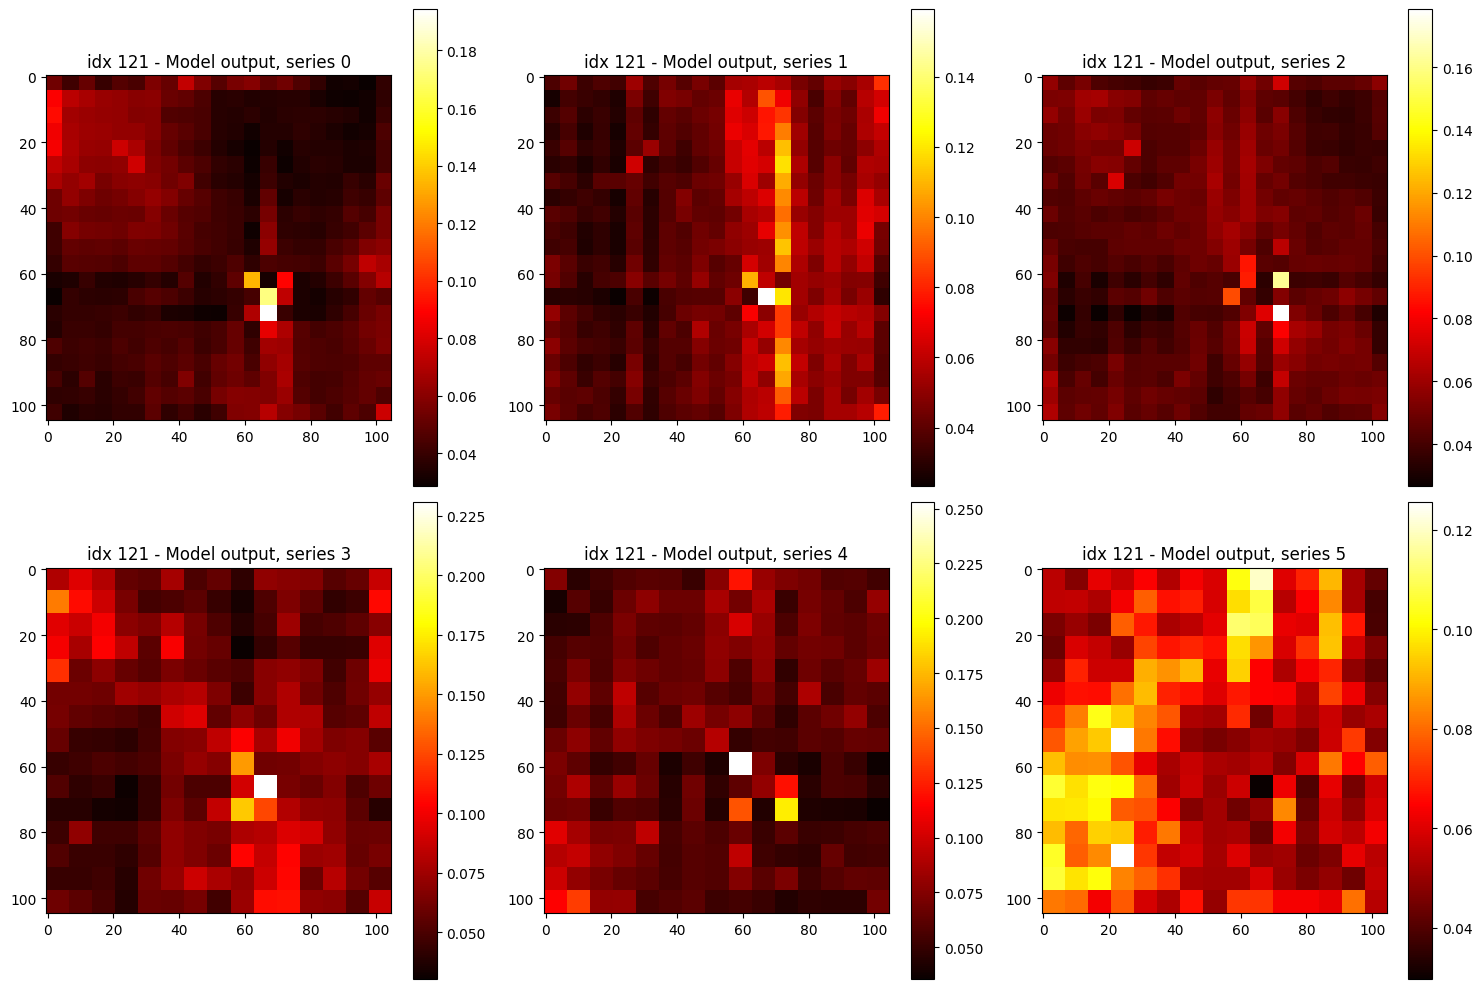

In [253]:
import matplotlib.pyplot as plt
import torch

fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns
axes = axes.flatten()  # Flatten for easy indexing

num_plots = min(len(series), 6)  # Show up to 6 images

for i in range(num_plots):
    attention_map = series[i]
    attention_map_first_element = attention_map[idx, 0, :, :]  # Shape: (105, 105)

    ax = axes[i]
    im = ax.imshow(attention_map_first_element.detach().cpu(), cmap='hot', interpolation='nearest')
    ax.set_title(f'idx {idx} - Model output, series {i}')
    fig.colorbar(im, ax=ax)

# Remove empty subplots if there are less than 6 plots
for j in range(num_plots, 6):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

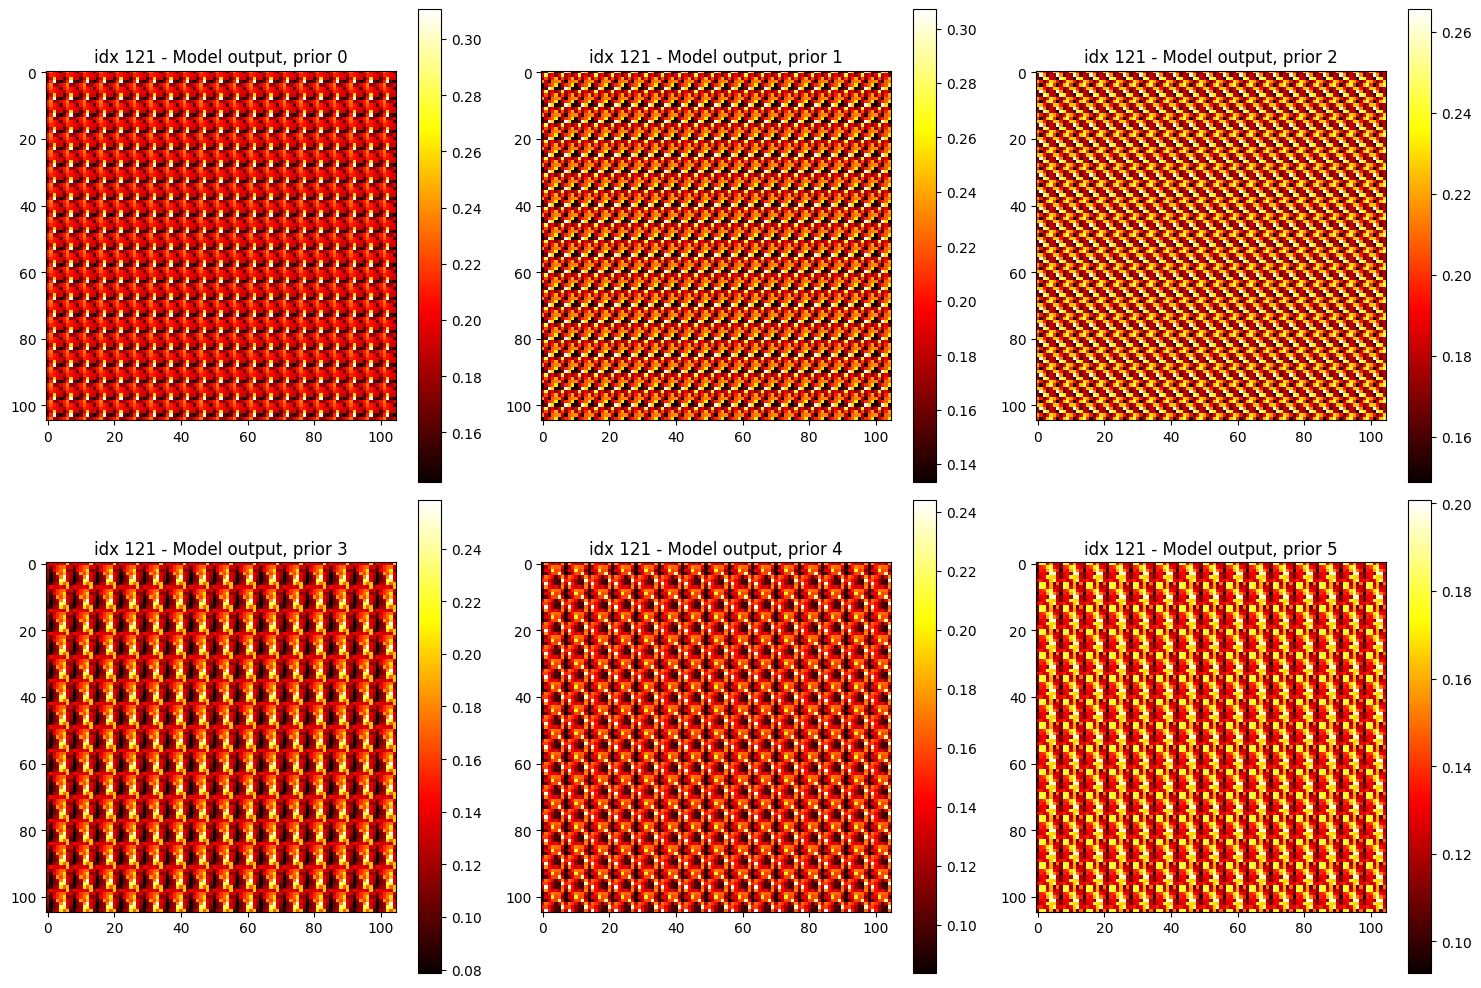

In [254]:
import matplotlib.pyplot as plt
import torch

fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns
axes = axes.flatten()  # Flatten for easy indexing

num_plots = min(len(prior), 6)  # Show up to 6 images

for i in range(num_plots):
    attention_map = prior[i]
    attention_map_first_element = attention_map[idx, 0, :, :]  # Shape: (105, 105)

    ax = axes[i]
    im = ax.imshow(attention_map_first_element.detach().cpu(), cmap='hot', interpolation='nearest')
    ax.set_title(f'idx {idx} - Model output, prior {i}')
    fig.colorbar(im, ax=ax)

# Remove empty subplots if there are less than 6 plots
for j in range(num_plots, 6):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [131]:
pred = np.load('pred_new.npy')
pred_adj = np.load('pred_adj_new.npy')
gt = np.load('gt.npy')
test_energy = np.load('test_energy_new.npy')

In [133]:
# data_iter = iter(solver.thre_loader)
# b = 3

# if b==0:
#     for input_data, label in solver.thre_loader:
#         break
# else:
#     for _ in range(b):
#         input_data, label = next(data_iter)

# print(input_data.shape)
# print(label.shape)
# print(torch.nonzero(label.sum(dim=1) > 0).squeeze())

In [149]:
import numpy as np
import pandas as pd
from scipy.ndimage import uniform_filter1d
import matplotlib.pyplot as plt

# Simulated anomaly score time series (100 time points)
np.random.seed(42)
test_energy = np.random.normal(loc=0.5, scale=0.1, size=100)  # Normal region
test_energy[70:80] += 1  # Introduce an anomaly (higher values)

# Adaptive threshold function
def adaptive_threshold(opt, combined_energy, window_size=20, percentile=99.5, k=3):
    print('adaptive threshold: ', opt)
    if opt == 'quantile':
        series = pd.Series(combined_energy)
        adaptive_thresh = series.rolling(window=window_size, min_periods=1).quantile(percentile / 100).to_numpy()
    elif opt == 'ma':  # Moving average + k*std
        moving_avg = uniform_filter1d(combined_energy, size=window_size, mode='nearest')
        moving_std = np.sqrt(uniform_filter1d((combined_energy - moving_avg) ** 2, size=window_size, mode='nearest'))
        adaptive_thresh = moving_avg + k * moving_std
    else:
        print('opt unnamed.')
        adaptive_thresh = np.zeros_like(combined_energy)
    return adaptive_thresh

thresh_quantile = adaptive_threshold("quantile", test_energy)
thresh_ma = adaptive_threshold("ma", test_energy)

# Compute anomaly predictions
pred_quantile = (test_energy > thresh_quantile).astype(int)
pred_ma = (test_energy > thresh_ma).astype(int)

# Print example results
print("🔹 Test Energy (First 10 values):\n", test_energy[:10])
print("🔹 Quantile Threshold (First 10 values):\n", thresh_quantile[:10])
print("🔹 Moving Avg + Std Threshold (First 10 values):\n", thresh_ma[:10])
print("🔹 Quantile-Based Predictions (First 10 values):\n", pred_quantile[:10])
print("🔹 Moving Avg + Std Predictions (First 10 values):\n", pred_ma[:10])

adaptive threshold:  quantile
adaptive threshold:  ma
🔹 Test Energy (First 10 values):
 [0.54967142 0.48617357 0.56476885 0.65230299 0.47658466 0.4765863
 0.65792128 0.57674347 0.45305256 0.554256  ]
🔹 Quantile Threshold (First 10 values):
 [0.54967142 0.54935393 0.56461788 0.65098997 0.6505523  0.65011463
 0.65775273 0.65772464 0.65769655 0.65766846]
🔹 Moving Avg + Std Threshold (First 10 values):
 [0.70505652 0.70145943 0.69829375 0.69890936 0.72508716 0.73546027
 0.73075698 0.72824934 0.73285696 0.72777186]
🔹 Quantile-Based Predictions (First 10 values):
 [0 0 1 1 0 0 1 0 0 0]
🔹 Moving Avg + Std Predictions (First 10 values):
 [0 0 0 0 0 0 0 0 0 0]


In [24]:
11000/105

104.76190476190476

In [ ]:
326103, 327317

anomalies:  17
anomalies (pred):  8


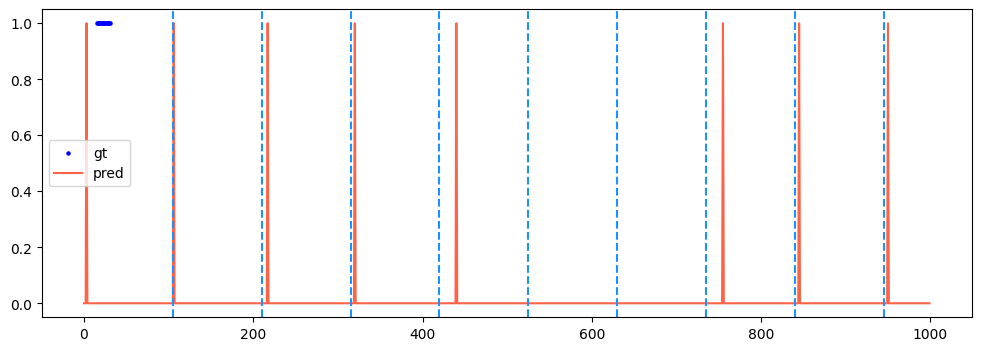

In [33]:
import matplotlib.pyplot as plt

point = 101*105
ran = slice(point, point+1000)
x = range(point, point+1000)

plt.figure(figsize=(12, 4)) 

# plt.plot(gt[ran], label='gt', color='blue', marker='o', markersize=2)  
gt_indices = np.where(gt[ran] == 1)[0]
try:
    plt.scatter(gt_indices, gt[ran][gt_indices], label='gt', color='blue', marker='o', s=5)
    print('anomalies: ', gt[ran].sum())
except:
    print('No anomaly')
plt.plot(pred[ran], label='pred', color='#FF6347')  
print('anomalies (pred): ', pred[ran].sum())
#plt.plot(pred_adj[ran], label='pred_adj', color='green', linestyle='--', marker='^', markersize=2)  

for i in range(105, 1000, 105):
    plt.axvline(x=i, color='#1E90FF', linestyle='--') 

plt.legend()
plt.show()

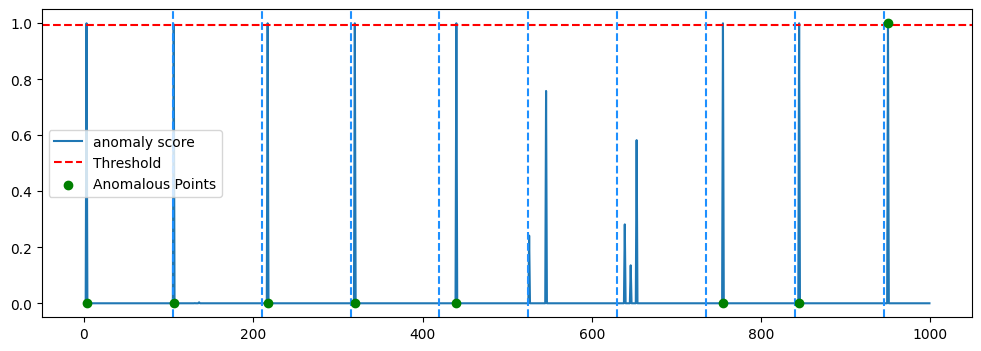

In [34]:
plt.figure(figsize=(12, 4)) 

thresh = 0.994474499940873
plt.plot(test_energy[ran], label='anomaly score')
plt.axhline(y=thresh, color='r', linestyle='--', label="Threshold") 

anomalous_indices = np.where(pred[ran]==1)[0] 
plt.scatter(anomalous_indices, pred[anomalous_indices], color='green', label='Anomalous Points', zorder=5)

for i in range(105, 1000, 105):
    plt.axvline(x=i, color='#1E90FF', linestyle='--') 

plt.legend()
plt.show() 

# for i in range(test.shape[1]):
#     plt.plot(test[ran][:, i])
#     plt.show()

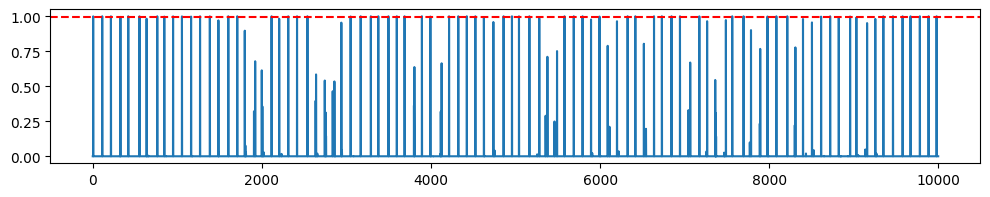

In [51]:
plt.figure(figsize=(12, 2)) 

thresh = 0.994474499940873
ran = slice(0, 10000)
plt.plot(test_energy[ran], label='anomaly score')
plt.axhline(y=thresh, color='r', linestyle='--', label="Threshold") 

# anomalous_indices = np.where(pred[ran]==1)[0] 
# plt.scatter(anomalous_indices, pred[anomalous_indices], color='green', label='Anomalous Points', zorder=5)

In [56]:
print(gt.sum())
print(pred.sum())

29319
4137


In [4]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(gt, pred)
precision, recall, f_score, support = precision_recall_fscore_support(gt, pred, average='binary')
print("Accuracy : {:0.4f}, Precision : {:0.4f}, Recall : {:0.4f}, F-score : {:0.4f} ".format(accuracy, precision, recall, f_score))

Accuracy : 0.9526, Precision : 0.0418, Recall : 0.0059, F-score : 0.0103 


In [5]:
accuracy = accuracy_score(gt, pred_adj)
precision, recall, f_score, support = precision_recall_fscore_support(gt, pred_adj, average='binary')
print("Accuracy : {:0.4f}, Precision : {:0.4f}, Recall : {:0.4f}, F-score : {:0.4f} ".format(accuracy, precision, recall, f_score))

Accuracy : 0.9880, Precision : 0.8626, Recall : 0.8486, F-score : 0.8555 


In [7]:
thresh_temp = 0.95
pred_temp = (test_energy > thresh_temp).astype(int)

accuracy = accuracy_score(gt, pred_temp)
precision, recall, f_score, support = precision_recall_fscore_support(gt, pred_temp, average='binary')
print("Accuracy : {:0.4f}, Precision : {:0.4f}, Recall : {:0.4f}, F-score : {:0.4f} ".format(accuracy, precision, recall, f_score))

Accuracy : 0.9512, Precision : 0.0400, Recall : 0.0071, F-score : 0.0120 


In [17]:
def point_adj(pred, gt):
    anomaly_state = False
    for i in range(len(gt)):
        if gt[i] == 1 and pred[i] == 1 and not anomaly_state:
            anomaly_state = True
            for j in range(i, 0, -1):
                if gt[j] == 0:
                    break
                else:
                    if pred[j] == 0:
                        pred[j] = 1
            for j in range(i, len(gt)):
                if gt[j] == 0:
                    break
                else:
                    if pred[j] == 0:
                        pred[j] = 1
        elif gt[i] == 0:
            anomaly_state = False
        if anomaly_state:
            pred[i] = 1

    pred = np.array(pred)
    gt = np.array(gt)
    
    return pred, gt

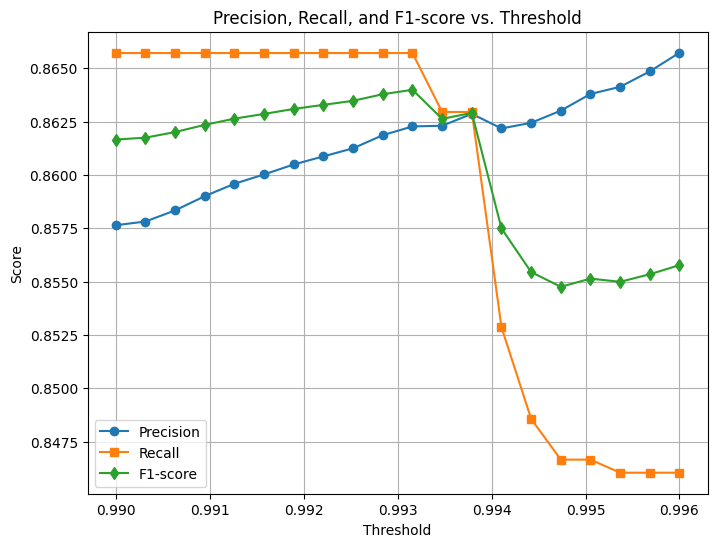

In [24]:
precisions = []
recalls = []
f_scores = []
thresholds = np.linspace(0.99, 0.996, 20)

for thresh_temp in thresholds:
    pred_temp = (test_energy > thresh_temp).astype(int)  
    
    pred_temp_adj, _ = point_adj(pred_temp, gt)

    precision, recall, f_score, _ = precision_recall_fscore_support(gt, pred_temp_adj, average='binary', zero_division=0)

    precisions.append(precision)
    recalls.append(recall)
    f_scores.append(f_score)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions, label="Precision", marker="o")
plt.plot(thresholds, recalls, label="Recall", marker="s")
plt.plot(thresholds, f_scores, label="F1-score", marker="d")

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1-score vs. Threshold")
plt.legend()
plt.grid()
plt.show()

#Accuracy : 0.9880, Precision : 0.8626, Recall : 0.8486, F-score : 0.8555 

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

#train_data = np.load("../dataset_anomaly/SMD/SMD_train.npy")[ran]
test_data = np.load("../dataset_anomaly/SMD/SMD_test.npy")
test_labels = np.load("../dataset_anomaly/SMD/SMD_test_label.npy")  # 0: normal, 1: anomaly

In [45]:
ran = slice(418500, 419000)

test_normal = test_data[ran][test_labels[ran] == 0]
test_anomalies = test_data[ran][test_labels[ran] == 1]
combined_data = np.vstack((test_normal, test_anomalies))
print(combined_data.shape)

(500, 38)


OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.


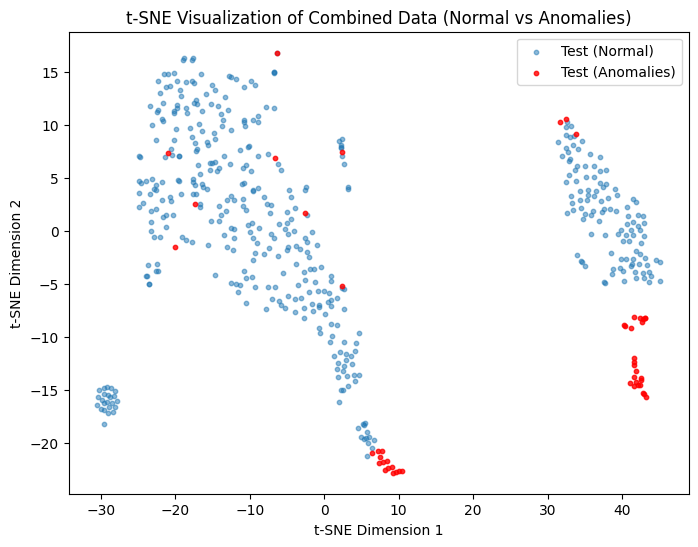

In [46]:


labels = np.concatenate([np.zeros(len(test_normal)), np.ones(len(test_anomalies))])
tsne = TSNE(n_components=2, perplexity=30, random_state=42)

tsne_results = tsne.fit_transform(combined_data)

# 결과 시각화
plt.figure(figsize=(8, 6))
plt.scatter(tsne_results[labels == 0, 0], tsne_results[labels == 0, 1], alpha=0.5, label="Test (Normal)", s=10)
plt.scatter(tsne_results[labels == 1, 0], tsne_results[labels == 1, 1], alpha=0.8, label="Test (Anomalies)", s=10, color='red')

plt.title("t-SNE Visualization of Combined Data (Normal vs Anomalies)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.show()

In [34]:
test_labels.shape

(708420,)

In [48]:
import numpy as np
import matplotlib.pyplot as plt

anomalies = test_labels == 1

anomaly_start_indices = np.where(np.diff(anomalies.astype(int)) == 1)[0] + 1
anomaly_end_indices = np.where(np.diff(anomalies.astype(int)) == -1)[0]

if anomalies[0] == 1:  
    anomaly_start_indices = np.insert(anomaly_start_indices, 0, 0)

if anomalies[-1] == 1: 
    anomaly_end_indices = np.append(anomaly_end_indices, len(anomalies) - 1)

plt.figure(figsize=(10, 6))

# # 아노말리 구간 시각화
# for start, end in zip(anomaly_start_indices, anomaly_end_indices):
#     plt.plot(np.arange(start, end + 1), anomalies[start:end + 1], color='red', lw=2)

# plt.title("Continuous Anomaly Periods")
# plt.xlabel("Time Index")
# plt.ylabel("Anomaly (1 = Anomaly, 0 = Normal)")
# plt.show()

for start, end in zip(anomaly_start_indices, anomaly_end_indices):
    print(f"Anomaly period from {start}, {end}, length: {end - start + 1}")

Anomaly period from 10620, 10636, length: 17
Anomaly period from 11785, 11815, length: 31
Anomaly period from 12765, 12785, length: 21
Anomaly period from 14068, 14071, length: 4
Anomaly period from 14520, 14530, length: 11
Anomaly period from 21287, 21297, length: 11
Anomaly period from 22072, 22076, length: 5
Anomaly period from 24370, 24372, length: 3
Anomaly period from 25810, 25812, length: 3
Anomaly period from 27250, 27252, length: 3
Anomaly period from 28690, 28692, length: 3
Anomaly period from 29736, 29739, length: 4
Anomaly period from 31371, 31374, length: 4
Anomaly period from 31569, 31572, length: 4
Anomaly period from 33010, 33012, length: 3
Anomaly period from 34450, 34452, length: 3
Anomaly period from 35805, 35832, length: 28
Anomaly period from 37329, 37330, length: 2
Anomaly period from 38640, 38643, length: 4
Anomaly period from 38769, 38771, length: 3
Anomaly period from 40240, 40262, length: 23
Anomaly period from 41684, 41686, length: 3
Anomaly period from 42345

<Figure size 1000x600 with 0 Axes>

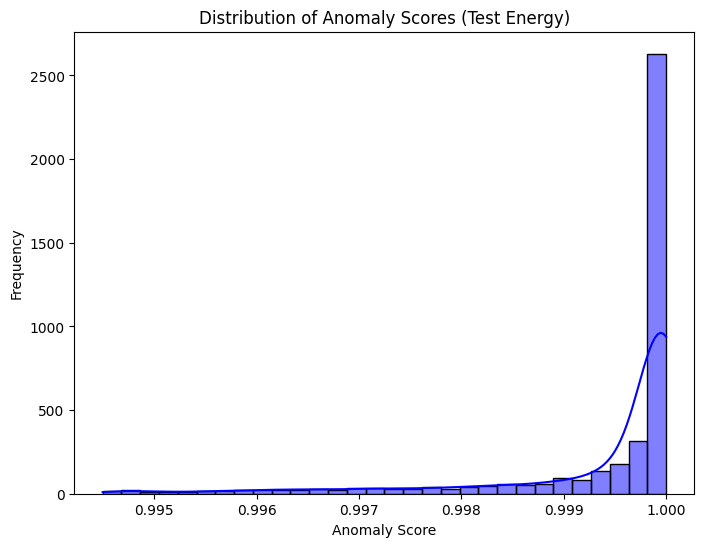

In [60]:
plt.figure(figsize=(8, 6))
sns.histplot(test_energy[test_energy > thresh], bins=30, kde=True, color='blue')
plt.title("Distribution of Anomaly Scores (Test Energy)")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.show()